### Multiclass Classification w/ Random-Forest and Transformer-based Embeddings

`Multiclass Classification` is a fundamental problem type in supervised learning where the goal is to classify instances into one or more classes. This notebook illustrates how to train a `random forest` model with hyperparameter tuning for multiclass classification. It then assesses the perfomance of combining said random forest with:
- [Cohere-embeddings](https://docs.cohere.com/reference/embed), and
- [bag-of-words vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

#### Random Forest

[Random forests](https://web.archive.org/web/20160417030218/http://ect.bell-labs.com/who/tkh/publications/papers/odt.pdf) is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. Random forests correct for decision trees' habit of overfitting to their training set

#### 1. Dataset Preparation

In [1]:
%pip install --upgrade cohere datasets python-dotenv scikit-learn tqdm --quiet

Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import time
import tqdm as notebook_tqdm

from datasets import load_dataset
from dotenv import find_dotenv, load_dotenv

SAMPLE_SIZE = 1000

The [AG_News](https://huggingface.co/datasets/ag_news) dataset is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification), information retrieval (ranking, search), data compression, data streaming, and any other non-commercial activity. For more information, please refer to http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

In [3]:
ds = load_dataset("ag_news", split="train")
ds

Dataset({
    features: ['text', 'label'],
    num_rows: 120000
})

Let's work with a smaller subset (by default 1000 samples). We shuffle the dataset to maintain the balance among classes.

In [4]:
ds_sm = ds.shuffle(seed=42).select(range(SAMPLE_SIZE))
ds_sm

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

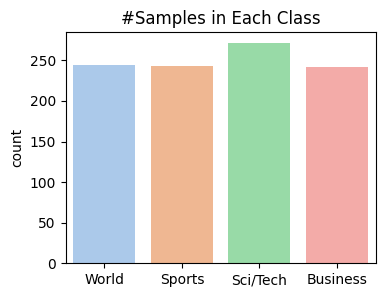

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["World", "Sports", "Business", "Sci/Tech"]
label_names = [class_names[label] for label in ds_sm['label']]

plt.figure(figsize=(4, 3))
sns.countplot(x=label_names, hue=label_names, palette="pastel")
plt.title("#Samples in Each Class")
plt.show()

----

#### 2. Random Forest with Transformed-based Embeddings (Cohere)

In [6]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [7]:
import cohere

_ = load_dotenv(find_dotenv()) # read local .env file
cohere_api_key = os.environ['COHERE_API_KEY']

##### 2.1 Vectorization with Cohere

Vectorize the texts using the [Cohere Embeddings](https://docs.cohere.com/reference/embed) model *embed-english-v2.0*, which provides 4096 dimensions.

In [8]:
co = cohere.Client(cohere_api_key)

# split ds_sm into 2 datasets to avoid hitting the rate limit
ds_sm1 = ds_sm.select(range(500))
ds_sm2 = ds_sm.select(range(500, 1000))

In [9]:
X_1 = co.embed( texts=ds_sm1['text'],
                model="embed-english-v2.0",
                truncate="END").embeddings

In [10]:
time.sleep(75)

In [11]:
X_2 = co.embed( texts=ds_sm2['text'],
                model="embed-english-v2.0",
                truncate="END").embeddings

In [12]:
# join X1 and X2
X_co = np.concatenate((X_1, X_2), axis=0)
# Cohere embeddings dimensions
len(X_co[0])

4096

In [13]:
# labels
y = ds_sm['label']

##### 2.2 Train Model w/ basic Hyperparameter Tuning

Unlike model parameters, which are learned from the data during training, `hyperparameters` are set prior to training and have a significant impact on how the model behaves and performs. For the sake of simplicity we aim to optimize just the following random-forest hyperparemeters:

- Number of Trees (`n_estimators`): Generally, more trees increase the model's performance and robustness but also increase computational complexity and training time.
- Maximum number of leaf nodes (`max_leaf_nodes`): This parameter can influence the shape and complexity of the trees that are created during training the model.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_co, y, test_size=0.25, random_state=42)

`GridSearchCV` evaluates all the possible combinations of hyperparameter values using `cross-validation`. With our param grid, the grid search will explore 6 combinations (2 from `n_estimator`, and 3 from `max_leaf_nodes`), and will train each model 3 times (since we are defining three-fold `cross-validation`) using all available CPU cores (`n_jobs=-1`). That is, 18 rounds of training.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [250, 500],
    'max_leaf_nodes': [8, 10, 12],
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the best model
co_clf = grid_search.best_estimator_

Best parameters: {'max_leaf_nodes': 12, 'n_estimators': 500}


##### 2.3 Assess Best Model Performance

In [16]:
y_pred = co_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.888
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        61
           1       0.93      0.90      0.91        69
           2       0.86      0.91      0.88        55
           3       0.81      0.88      0.84        65

    accuracy                           0.89       250
   macro avg       0.89      0.89      0.89       250
weighted avg       0.89      0.89      0.89       250



----

#### 3. Random Forest with Bag-of-Words Embeddings (CountVectorizer)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

##### 3.1 Vectorization with CountVectorizer

`CountVectorizer` is used to transform a block of text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. In practice the process is as follows:

- *Tokenization*: It splits the text into individual words (tokens). By default, it splits text by whitespace and punctuation.
- *Lowercasing*: All words are converted to lowercase to ensure that the same word in different cases is counted as the same token.
- *Filtering Stop Words*: Optionally, it can remove common words ('stop words') that usually don't carry much meaning.
- *Counting*: It counts the occurrences of each unique token in each document.
- *Vectorization*: Finally, it converts the counts into a numerical format suitable for machine learning algorithms, creating a document-term matrix. Each document is represented as a row, and each unique token is represented as a column. The value in each cell is the count of the token in that particular document.

In [18]:
vectorizer = CountVectorizer()
X_cv = vectorizer.fit_transform(ds_sm['text'])
X_cv.shape

(1000, 7764)

In [19]:
# labels
y = ds_sm['label']

##### 3.2 Train Model w/ basic Hyperparameter Tuning

Unlike model parameters, which are learned from the data during training, `hyperparameters` are set prior to training and have a significant impact on how the model behaves and performs. For the sake of simplicity we aim to optimize:

- Number of Trees (`n_estimators`): Generally, more trees increase the model's performance and robustness but also increase computational complexity and training time.
- Maximum number of leaf nodes (`max_leaf_nodes`): This parameter can influence the shape and complexity of the trees that are grown during the training of the model.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_cv, y, test_size=0.25, random_state=42)

`GridSearchCV` evaluates all the possible combinations of hyperparameter values using `cross-validation`. With our param grid, the grid search will explore 6 combinations (2 from `n_estimator`, and 3 from `max_leaf_nodes`), and will train each model 3 times (since we are defining three-fold `cross-validation`) using all available CPU cores (`n_jobs=-1`). That is, 18 rounds of training.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [250, 500],
    'max_leaf_nodes': [8, 10, 12],
}

clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best parameters:", best_params)

cv_clf = grid_search.best_estimator_

Best parameters: {'max_leaf_nodes': 12, 'n_estimators': 250}


##### 3.3 Assess Model Performance

In [22]:
y_pred = cv_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.93      0.62      0.75        61
           1       0.83      0.51      0.63        69
           2       0.79      0.67      0.73        55
           3       0.46      0.85      0.59        65

    accuracy                           0.66       250
   macro avg       0.75      0.66      0.67       250
weighted avg       0.75      0.66      0.67       250



----